In [3]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import collections.abc
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
sns.set_style("ticks")
sns.set_context("talk")

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            if type(v) == list:
                if type(v[1]) == str:
                    items.append((new_key, v[0]))
                    items.append((new_key + "_unit", v[1]))
                else:
                    for it, v_ in enumerate(v):
                        items.append((new_key + f"_{it}", v_))

            else:
                items.append((new_key, v))
    return dict(items)

# Data Gathering

In [4]:
# Load data into dictionary
with open("quarzi.json") as f :
    data = json.load(f)
    
# Flatten all nested dictionaries
data = [flatten(d) for d in data]
# Transform into dataframe, setting nans to 0 and renaming the most important time column
df = pd.DataFrame.from_dict(data).dropna(0)
df = df.rename(columns = {'clocks_PWSCF': 'time'})

In [5]:
# Remove rows that only contain one unique value and transform all to float
df_clean = pd.DataFrame()
for c in list(df.columns):
    if len(df[c].unique()) > 1:
        try:
            df_clean[c] = df[c].astype('float')
        except ValueError:
            pass

In [11]:
# Remove columns with correlation > .999 w.r.t. other columns, and clock columns

columns_tokeep = df_clean.columns
correlation = df_clean.corr(method='pearson') >= 0.999
for c in list(df_clean.columns):
    if not c.startswith('clocks_'):
        for c1 in list(df_clean.columns[correlation[c].values]):
            if c != c1:
                try:
                    columns_tokeep = columns_tokeep.drop(c1)
                except:
                    pass
    else:
        columns_tokeep = columns_tokeep.drop(c)

df_x = df_clean[columns_tokeep]

df_x.head()

,time,dims_nkpoints,dims_MPI tasks,dims_Threads,dims_npool,dims_n_RG,dims_wfc_fft_division_0,dims_wfc_fft_division_1,dims_ndiag,RAM_static_per_process,RAM_max_per_process,RAM_total,RAM_wfc (w. buffer),"RAM_h,s,v(r/c)",RAM_<psi|beta>,RAM_wfcinit/wfcrot
1,135.36,4.0,384.0,2.0,4.0,96.0,2.0,48.0,81.0,66.13,170.82,64.06,12.73,1.32,27.0,68.56
2,227.50,4.0,384.0,2.0,2.0,192.0,2.0,96.0,169.0,46.56,112.38,42.14,19.09,0.64,27.0,49.47
3,254.08,4.0,192.0,2.0,2.0,96.0,8.0,12.0,81.0,91.74,207.98,39.00,38.18,1.32,27.0,68.56
4,265.10,4.0,192.0,2.0,2.0,96.0,2.0,48.0,81.0,91.59,207.63,38.93,38.18,1.32,27.0,68.56
5,232.12,4.0,192.0,2.0,4.0,48.0,8.0,6.0,36.0,131.76,314.48,58.96,25.45,3.00,27.0,106.74


In [7]:
# Create normalized Dataset
mean = df_x.mean()
std = df_x.std()
df_norm = (df_x - mean)/std

# Crete training and test set

In [8]:
# Create training and test set
np.random.seed(0)
msk = np.random.rand(len(df_norm)) < 0.8
df_train = df_norm[msk]
df_val = df_norm[~msk]

X_tr = df_train.drop(['time'], axis=1).values
Y_tr = df_train['time'].values

X_val = df_val.drop(['time'], axis=1).values
Y_val = df_val['time'].values

# Linear Regression

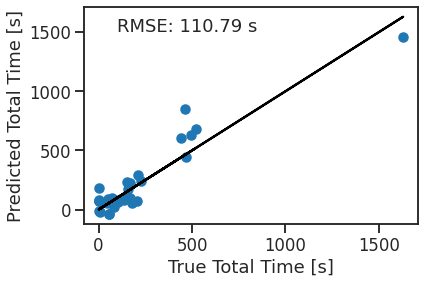

In [9]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_tr, Y_tr)
Y_hat = reg.predict(X_val)

plt.scatter(Y_val*std['time'] + mean['time'], Y_hat*std['time'] + mean['time'])
plt.plot(Y_val*std['time'] + mean['time'], Y_val*std['time'] + mean['time'], 'k-')
rmse = mean_squared_error(Y_val*std['time'] + mean['time'], Y_hat*std['time'] + mean['time'])**0.5
plt.xlabel("True Total Time [s]")
plt.ylabel("Predicted Total Time [s]")
plt.text(100, 1500, "RMSE: %.2f s" %(rmse))
plt.show()

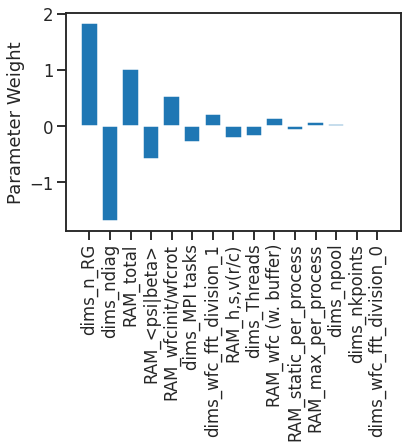

In [57]:
ordering = np.argsort(abs(reg.coef_))[::-1]
plt.bar(df_train.drop(['time'], axis=1).columns[ordering], reg.coef_[ordering])
plt.xticks(rotation='vertical')
plt.ylabel("Parameter Weight")
plt.show()

# LASSO

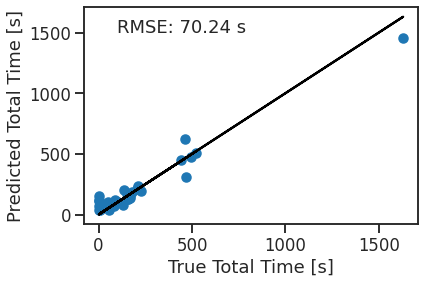

In [64]:
from sklearn.linear_model import Lasso
clf = Lasso(alpha=.05).fit(X_tr, Y_tr)
Y_hat = clf.predict(X_val)

plt.scatter(Y_val*std['time'] + mean['time'], Y_hat*std['time'] + mean['time'])
plt.plot(Y_val*std['time'] + mean['time'], Y_val*std['time'] + mean['time'], 'k-')
rmse = mean_squared_error(Y_val*std['time'] + mean['time'], Y_hat*std['time'] + mean['time'])**0.5
plt.xlabel("True Total Time [s]")
plt.ylabel("Predicted Total Time [s]")
plt.text(100, 1500, "RMSE: %.2f s" %(rmse))
plt.show()

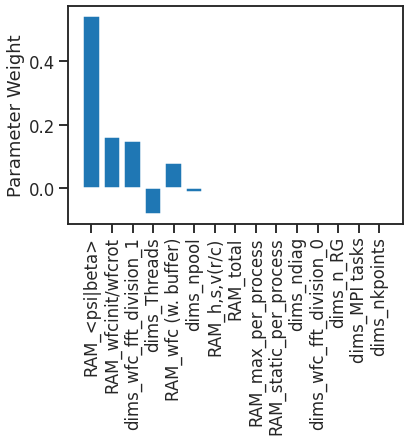

In [65]:
ordering = np.argsort(abs(clf.coef_))[::-1]
plt.bar(df_train.drop(['time'], axis=1).columns[ordering], clf.coef_[ordering])
plt.xticks(rotation='vertical')
plt.ylabel("Parameter Weight")
plt.show()

# Gaussian Process Regression

In [298]:
import GPy

# Create kernel with 1 independent RBF per component
k1  = GPy.kern.RBF(input_dim=1, active_dims = [0])
k2  = GPy.kern.RBF(input_dim=1, active_dims = [1])
k3  = GPy.kern.RBF(input_dim=1, active_dims = [2])
k4  = GPy.kern.RBF(input_dim=1, active_dims = [3])
k5  = GPy.kern.RBF(input_dim=1, active_dims = [4])
k6  = GPy.kern.RBF(input_dim=1, active_dims = [5])
k7  = GPy.kern.RBF(input_dim=1, active_dims = [6])
k8  = GPy.kern.RBF(input_dim=1, active_dims = [7])
k9  = GPy.kern.RBF(input_dim=1, active_dims = [8])
k10 = GPy.kern.RBF(input_dim=1, active_dims = [9])
k11 = GPy.kern.RBF(input_dim=1, active_dims = [10])
k12 = GPy.kern.RBF(input_dim=1, active_dims = [11])
k13 = GPy.kern.RBF(input_dim=1, active_dims = [12])
k14 = GPy.kern.RBF(input_dim=1, active_dims = [13])
k15 = GPy.kern.RBF(input_dim=1, active_dims = [14])

k = k1*k2*k3*k4*k5*k6*k7*k8*k9*k10*k11*k12*k13*k14*k15

# Optimize hyperparameters automatically and fit
m = GPy.models.GPRegression(X_tr, Y_tr.reshape(len(Y_tr), 1), kernel = k, noise_var = 0.4)
opts = m.optimize(messages=True)

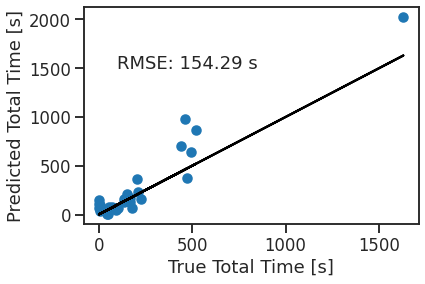

In [329]:
Y_hat = m.predict(X_val)[0]

plt.scatter(Y_val*std['time'] + mean['time'], Y_hat*std['time'] + mean['time'])
plt.plot(Y_val*std['time'] + mean['time'], Y_val*std['time'] + mean['time'], 'k-')
rmse = mean_squared_error(Y_val*std['time'] + mean['time'], Y_hat*std['time'] + mean['time'])**0.5
plt.xlabel("True Total Time [s]")
plt.ylabel("Predicted Total Time [s]")
plt.text(100, 1500, "RMSE: %.2f s" %(rmse))
plt.show()